In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import utilities
from descriptor import rdkitDescriptors

In [2]:
df=pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] =utilities.clean_out_of_bound(df['value (% BOD)'])

In [3]:
features = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'])

In [4]:
smiles_features=pd.concat([df['SMILES'],features], axis=1)

## 1 Divide the feature columns by dtypes (float and int)

### 1.1 int features

In [5]:
feat_int =features.select_dtypes(include=['int64'])
selected_int_feat = feat_int.loc[:,feat_int.nunique()>1]
len(selected_int_feat.loc[0])

40

### 1.2 float features

In [6]:
feat_float = features.select_dtypes(include=['float64'])
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
len(selected_float_feat.loc[0])

87

## 2 Divide BOD by different cutoff

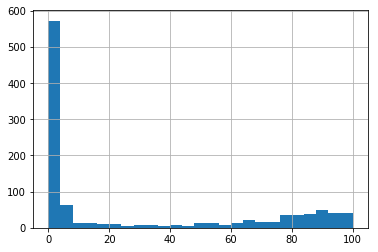

In [7]:
df['cleaned_bod'].hist(bins=25)

### 2.1 50% quantile two classes

(array([535.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 528.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

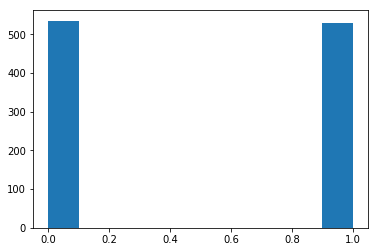

In [8]:
df['bi_class_q50']=pd.qcut(df['cleaned_bod'].values, 2, labels=[0,1])
true_label_q50 = df['bi_class_q50'].values
plt.hist(true_label_q50)

### 2.2 33%, 66% quantile 3 classes (manual implement due to duplicate edges)

(array([413.,   0.,   0.,   0.,   0., 288.,   0.,   0.,   0., 362.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

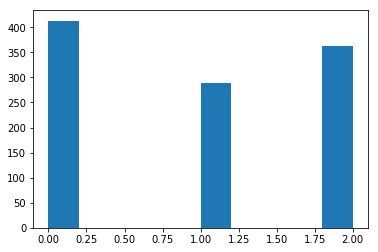

In [9]:
tri_cuts=df['cleaned_bod'].quantile([0.33,0.66]).values
df['tri_class_q33']=utilities.divide_classes(df['cleaned_bod'], tri_cuts)
true_label_q33=df['tri_class_q33'].values
plt.hist(true_label_q33)

### 2.3 25%, 50%, 75% 4 classes (manual)

(array([413.,   0.,   0., 122.,   0.,   0., 262.,   0.,   0., 266.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

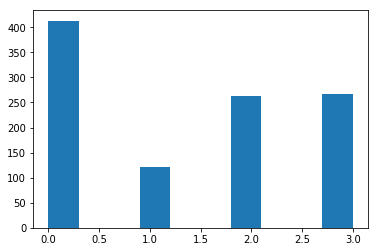

In [10]:
quart_cuts=df['cleaned_bod'].quantile([0.25,0.50,0.75]).values
df['quart_class_q25']=utilities.divide_classes(df['cleaned_bod'], quart_cuts)
true_label_q25 = df['quart_class_q25'].values
plt.hist(true_label_q25) #inbalanced

### 2.4 Partitioning into bi classes based on distribution

(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

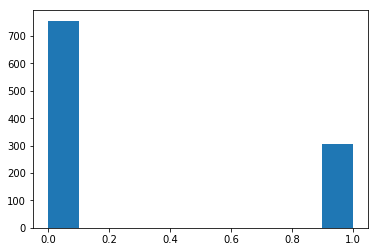

In [11]:
df['bi_class_partition']=utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

### 2.5 Partitioning into three classes (poor, median, good) based on distribution

(array([673.,   0.,   0.,   0.,   0., 191.,   0.,   0.,   0., 199.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

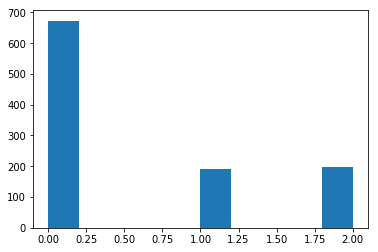

In [12]:
df['tri_class_partition']=utilities.divide_classes(df['cleaned_bod'], [20,80])
true_label_triclass = df['tri_class_partition'].values
plt.hist(df['tri_class_partition'])

## 3 Baseline Model -- Kmeans

In [13]:
from cluster import KMeans

## 3.1 bi-class 50 quantile cluster

### 3.1.1 int feature

In [14]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_kmeans_cluster()
kmeans_cluster.train_model(selected_int_feat.values, true_labels=true_label_q50)

Metrics without ture labels
silhouette score: 0.5475756430178326
calinski score: 675.2304536098828
davie bouldin score: 1.0107598758571776

Metric with True label
adjusted rand score: 0.001795278078604992 
adjusted mutual info score: 0.00195655374386627
homogeneity completeness v measure:
(0.002636005876416948, 0.004280409317187768, 0.0032627260792584697)
fowlkes_mallows : 0.6093197129654911


/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(array([0, 0, 0, ..., 1, 1, 0], dtype=int32),
 {'silhouette_score': 0.5475756430178326,
  'calinski_score': 675.2304536098828,
  'davie_bouldin_score': 1.0107598758571776,
  'adjusted_rand_score': 0.001795278078604992,
  'adjusted_mutual_info_score': 0.00195655374386627,
  'homogeneity_completeness_v_measure': (0.002636005876416948,
   0.004280409317187768,
   0.0032627260792584697),
  'fowlkes_mallows_score': 0.6093197129654911})

### 3.1.2 float feature

In [15]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_kmeans_cluster()
kmeans_cluster.train_model(selected_float_feat.values, true_labels=true_label_q50)

Metrics without ture labels
silhouette score: 0.9772412798979195
calinski score: 2449.94638482056
davie bouldin score: 0.015276316032467912

Metric with True label
adjusted rand score: -2.4617415490710395e-05 
adjusted mutual info score: -8.89558430810096e-06
homogeneity completeness v measure:
(0.0009324855614722467, 0.08622182815151025, 0.0018450173355687419)
fowlkes_mallows : 0.7061152060370829


/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 {'silhouette_score': 0.9772412798979195,
  'calinski_score': 2449.94638482056,
  'davie_bouldin_score': 0.015276316032467912,
  'adjusted_rand_score': -2.4617415490710395e-05,
  'adjusted_mutual_info_score': -8.89558430810096e-06,
  'homogeneity_completeness_v_measure': (0.0009324855614722467,
   0.08622182815151025,
   0.0018450173355687419),
  'fowlkes_mallows_score': 0.7061152060370829})

## 3.2 Comparison between different cuts

1. bi-class 50 quantile cluster
2. tri-class 33 quantile cluster
3. quart-class 25 quantile cluster
4. bi-class with customed partition \[0,60\%\], (60\%,100\%\]
5. tri-class with customed partition \[0,20\%\], (20\%,80\%\], (80\%,100\%\]

In [16]:
n_clusters   = [2, 3, 4, 2, 3]
true_labels  = [true_label_q50, true_label_q33, true_label_q25, true_label_biclass, true_label_triclass]
cluster_name = ['bi_class_50_quantile', 'tri_class_33_quantile', 
                'quart_class_25_quantile', 'bi_class_customed_partition','tri_class_customed_partition']

### 3.2.1 int feature

In [17]:
kmeans_cluster = KMeans(n_clusters=2)
metrics = []
for i in range(len(n_clusters)):
    kmeans_cluster.n_clusters = n_clusters[i]
    kmeans_cluster.bulid_kmeans_cluster()
    a, metric = kmeans_cluster.train_model(selected_int_feat.values, 
                                           true_labels=true_labels[i],
                                           print_metric=False)
    metrics.append(metric)

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

In [18]:
int_metrics_df = pd.DataFrame(columns=metrics[0].keys())
int_metrics_df['clusters'] = cluster_name
int_metrics_df = int_metrics_df.set_index('clusters')

for i in range(len(metrics)):
    int_metrics_df.loc[cluster_name[i]] = pd.Series(metrics[i])

int_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.547576,675.23,1.01076,0.00179528,0.00195655,"(0.002636005876416948, 0.004280409317187768, 0...",0.60932
tri_class_33_quantile,0.350802,552.613,1.24896,0.0233645,0.0286024,"(0.03029183491865626, 0.04005681517080529, 0.0...",0.430557
quart_class_25_quantile,0.3497,518.136,1.14458,0.0217047,0.0340189,"(0.03724854901918152, 0.052258284260218495, 0....",0.385071
bi_class_customed_partition,0.547576,675.23,1.01076,-0.00233091,-0.000769174,"(1.720871726609063e-05, 2.4232974327895367e-05...",0.659918
tri_class_customed_partition,0.350802,552.613,1.24896,-0.0148375,0.0334904,"(0.03550161262866302, 0.039332154440103115, 0....",0.48101


### 3.2.1 float feature

In [19]:
kmeans_cluster = KMeans(n_clusters=2)
metrics = []
for i in range(len(n_clusters)):
    kmeans_cluster.n_clusters = n_clusters[i]
    kmeans_cluster.bulid_kmeans_cluster()
    a, metric = kmeans_cluster.train_model(selected_float_feat.values, 
                                           true_labels=true_labels[i],
                                           print_metric=False)
    metrics.append(metric)

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / ce

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / ce

In [20]:
float_metrics_df = pd.DataFrame(columns=metrics[0].keys())
float_metrics_df['clusters'] = cluster_name
float_metrics_df = float_metrics_df.set_index('clusters')

for i in range(len(metrics)):
    float_metrics_df.loc[cluster_name[i]] = pd.Series(metrics[i])

float_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.977241,2449.95,0.0152763,-2.46174e-05,-8.89558e-06,"(0.0009324855614722467, 0.08622182815151025, 0...",0.706115
tri_class_33_quantile,0.514583,2303.94,0.670436,0.00476539,0.00404363,"(0.00584537357235193, 0.01223698843892061, 0.0...",0.479043
quart_class_25_quantile,0.438957,1993.12,0.807871,0.00455626,0.00688868,"(0.010014670115448846, 0.018603372312919936, 0...",0.408747
bi_class_customed_partition,0.977241,2449.95,0.0152763,-0.00111652,-0.000408164,"(0.0005336913207279748, 0.042794164058525395, ...",0.766324
tri_class_customed_partition,0.514583,2303.94,0.670436,-0.0303483,0.00613072,"(0.008097131175260132, 0.014201763387349176, 0...",0.544949


In [21]:
int_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.547576,675.23,1.01076,0.00179528,0.00195655,"(0.002636005876416948, 0.004280409317187768, 0...",0.60932
tri_class_33_quantile,0.350802,552.613,1.24896,0.0233645,0.0286024,"(0.03029183491865626, 0.04005681517080529, 0.0...",0.430557
quart_class_25_quantile,0.3497,518.136,1.14458,0.0217047,0.0340189,"(0.03724854901918152, 0.052258284260218495, 0....",0.385071
bi_class_customed_partition,0.547576,675.23,1.01076,-0.00233091,-0.000769174,"(1.720871726609063e-05, 2.4232974327895367e-05...",0.659918
tri_class_customed_partition,0.350802,552.613,1.24896,-0.0148375,0.0334904,"(0.03550161262866302, 0.039332154440103115, 0....",0.48101
